## Model initialization

In [1]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
from ema_workbench import (RealParameter, IntegerParameter,
                           TimeSeriesOutcome, ScalarOutcome, 
                           ema_logging, perform_experiments)
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework import (salib_samplers, IpyparallelEvaluator, samplers, util,
                                        MultiprocessingEvaluator, SequentialEvaluator) 
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy.lib.recfunctions as rf
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd

C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model = ExcelModel("excelmodel", wd="./Models", model_file='MIDDEN Decarbonization options salt.xlsx')

#name of the sheet
model.sheet = "Experiment"

# Specification of the uncertainties
model.uncertainties = [IntegerParameter("Price_scenario", 1, 3),             # Integer value 1, 2, 3
                       RealParameter("Discount_rate", 0.01, 0.05),           # May fluctuate between 2% and 5%
                       RealParameter("Production_uncertainty", 0.90, 1.10),  # May fluctuate between between 85% and 115% 
                       RealParameter("Efficiency_gain", 0.003, 0.007),       # Yearly efficiency gain approx 0.5% (DNGVL)
                       #IntegerParameter("Plant_number", 1, 4),               # 1=Hengelo; 2=Delfzijl; 3=Harlingen; 4=Veendam
                       IntegerParameter("Investment_year", 2020, 2030)       # Integer value range 2020 – 2030
                      ]


# Specification of the policies
model.levers = [IntegerParameter('Decarbonization_pathway', 0, 3), # 0=None; 1=Electric boilers; 2=MVR technology; 3=Hybrid
                IntegerParameter('Energy_tax', 0, 2)               # 0=None; 1=10%; 2=20%
               ]

# Specification of the outcomes
model.outcomes = [ScalarOutcome('IRR', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("P_direct_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("P_indirect_emission_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("NPV", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Energy_usage_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Direct_emissions_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emissions_change", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Emissions_change", kind=ScalarOutcome.MINIMIZE)
                 ]

 ### Running experiment with policies


In [3]:
#Running with policies
n_scenarios = 1000
n_policies = 12

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies)

#Running in series
#results = perform_experiments(model, n_scenarios)
#experiments, outcomes = results

#Running in parallel
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)
experiments, outcomes = results

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 12 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[SpawnPoolWorker-1/INFO] finalizing
[SpawnPoolWorker-2/INFO] finalizing


In [4]:
# Inspection of outcomes of interest
oois = outcomes.keys()
for ooi in oois:
    value = outcomes[ooi]
    i=len(ooi)
    print(ooi, (20-i)*" ", np.mean(value), 3*" ", np.std(value))

IRR                   0.170403047424     0.273063627239
P_direct_emission_change  -0.743551376527     0.405261795827
P_indirect_emission_change  14.8639512863     10.5005946015
NPV                   6463795.25717     112926739.303
Energy_usage_change   1997598.50864     2312735.12054
Direct_emissions_change  -184.611875104     101.346647022
Indirect_emissions_change  299.903137403     227.461907566
Emissions_change      115.291262299     162.643285784


In [5]:
# Creating experiment DataFrame
experiment_data=pd.DataFrame(experiments)
outcome_data = pd.DataFrame(outcomes)

In [6]:
results_df=pd.concat([experiment_data, outcome_data], axis=1)
results_df.head(3)

,Discount_rate,Efficiency_gain,Investment_year,Price_scenario,Production_uncertainty,Decarbonization_pathway,Energy_tax,scenario_id,policy,model,Direct_emissions_change,Emissions_change,Energy_usage_change,IRR,Indirect_emissions_change,NPV,P_direct_emission_change,P_indirect_emission_change
0,0.010109,0.003632,2030,1,0.994345,1,2,0,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel,-246.877890,189.047133,5.633962e+06,0.0,435.925024,-1.922051e+07,-1.0,29.348107
1,0.019915,0.004686,2020,2,0.993022,1,2,1,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel,-246.549566,203.459581,5.943778e+06,0.0,450.009148,-2.219535e+08,-1.0,29.859957
2,0.021950,0.003177,2027,3,1.041452,1,2,2,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel,-258.573661,205.554198,6.064265e+06,0.0,464.127859,-3.083099e+07,-1.0,29.301065


## Scenario discovery

In [7]:
outcome_data_test=outcome_data
outcome_data_test['P_direct_emission_change_negative']=outcome_data_test.P_direct_emission_change<0
outcome_data_test['P_indirect_emission_change_negative']=outcome_data_test.P_indirect_emission_change<5.25
outcome_data_test['P_both_emission_change_negative']=outcome_data_test['P_direct_emission_change_negative']&outcome_data_test['P_indirect_emission_change_negative']
outcome_data_test['IRR_positive']=outcome_data_test.IRR>0


In [8]:
experiment_data.head(3)

,Discount_rate,Efficiency_gain,Investment_year,Price_scenario,Production_uncertainty,Decarbonization_pathway,Energy_tax,scenario_id,policy,model
0,0.010109,0.003632,2030,1,0.994345,1,2,0,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel
1,0.019915,0.004686,2020,2,0.993022,1,2,1,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel
2,0.021950,0.003177,2027,3,1.041452,1,2,2,"{'Decarbonization_pathway': 1, 'Energy_tax': 2}",excelmodel


In [9]:
# Selecting relevant dataframes for scenario analysis
#x_df=experiment_data.ix[:,0:5]
x_df=experiment_data[['Discount_rate','Efficiency_gain','Production_uncertainty','Investment_year']]
y_df=outcome_data['P_direct_emission_change_negative']&outcome_data_test['IRR_positive']#&outcome_data_test['P_indirect_emission_change_negative']

# Converting dataframes to arrays
x = x_df.to_records(index=False)
y = y_df.values

# Running the Patient rule induction (PRIM) algorithm 
prim_alg = prim.Prim(x,y, threshold=0.3)
box_1 = prim_alg.find_box()

[MainProcess/INFO] 12000 points remaining, containing 5069 cases of interest
[MainProcess/INFO] mean: 0.5267175572519084, mass: 0.131, coverage: 0.16334582757940422, density: 0.5267175572519084 restricted_dimensions: 3.0


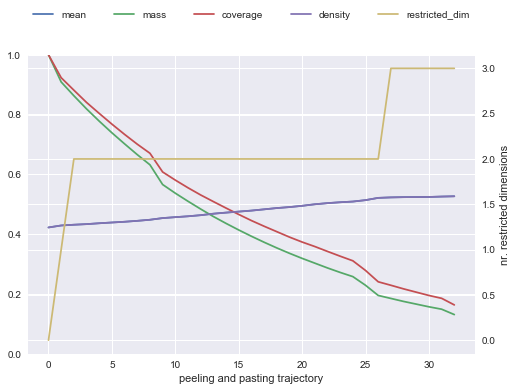

In [10]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

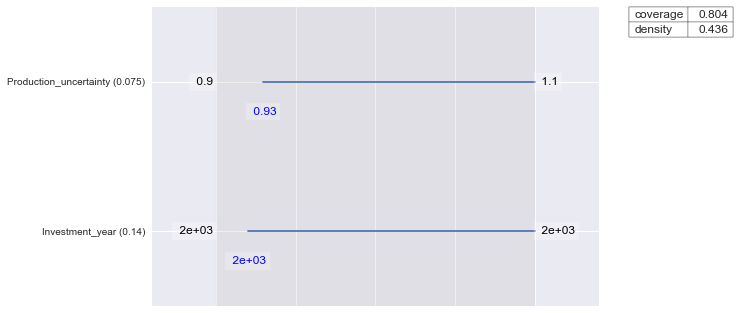

In [11]:
box_1.inspect(4, style='graph')
plt.show()

## Basic analysis of results

In [12]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

[MainProcess/INFO] no time dimension found in results


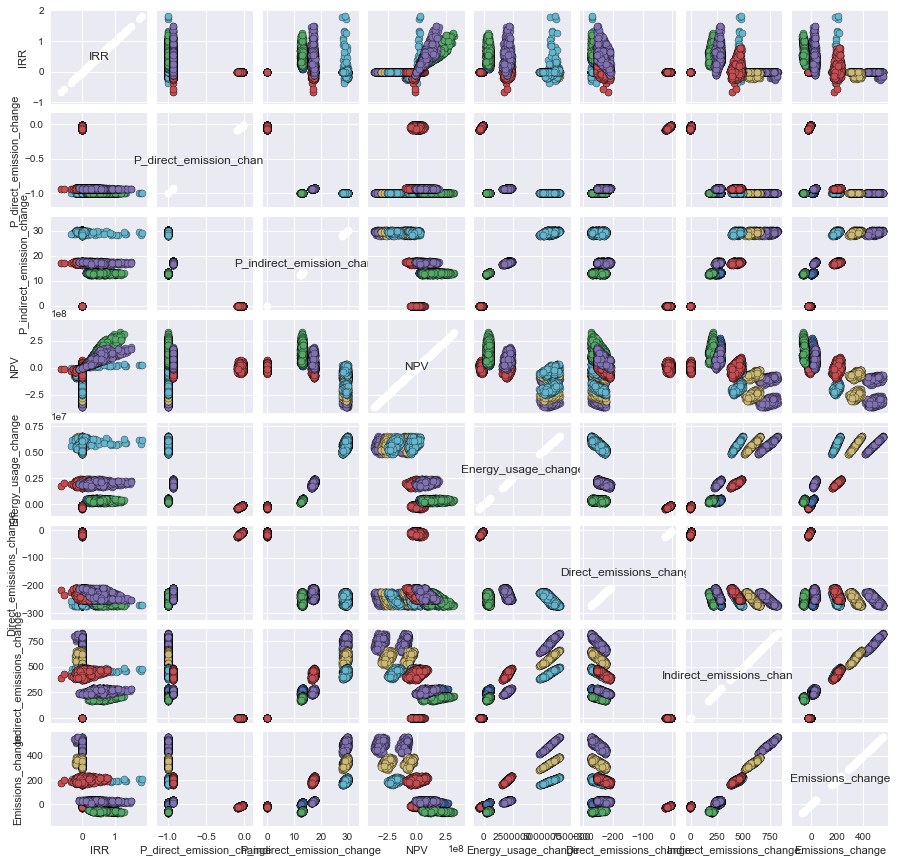

In [13]:
import ema_workbench.analysis.pairs_plotting as pairs

fig, axes = pairs.pairs_scatter(results, group_by='policy', legend=False)

#change_fontsize(fig)
fig.set_figheight(15)
fig.set_figwidth(15)

for ax in axes.values():
    ax.locator_params(nbins=4)
#save_fig(fig, './figs/', 'pair_plot')

plt.show()

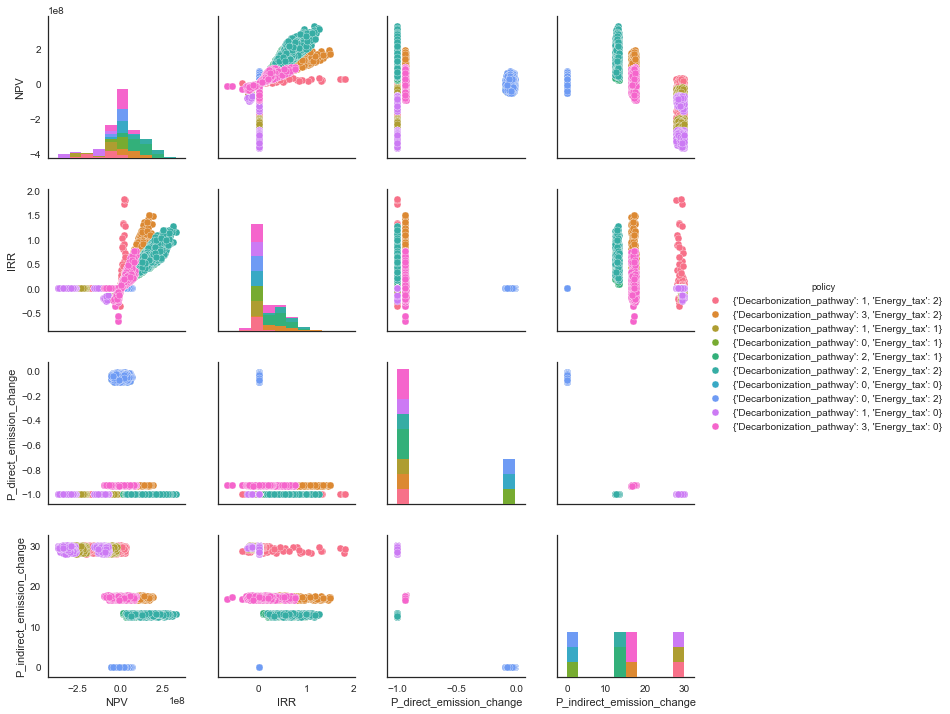

In [14]:
import copy
experiments, outcomes = results
policy_column = experiments['policy']

data = copy.copy(outcomes)
data['policy'] = policy_column
data.keys()
data = pd.DataFrame(data)
plotdata=data[['NPV','IRR','P_direct_emission_change','P_indirect_emission_change','policy']]
#for entry, name in zip(np.unique(policy_column), 'abcd'):
#    data.replace(entry, name, inplace=True)

sns.set(style="ticks", color_codes=True)    
with sns.axes_style('white'):
    sns.pairplot(plotdata, hue='policy')
plt.show()

## Policy optimization

In [15]:
import functools
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.evaluators import (optimize, robust_optimize)

In [16]:
with MultiprocessingEvaluator(model) as evaluator:
    optimization_results = evaluator.optimize(searchover='levers', nfe=1000, epsilons=[0.1,]*len(model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] terminating pool


AttributeError: 'NoneType' object has no attribute 'Real'

In [ ]:
MAXIMIZE = ScalarOutcome.MAXIMIZE  # @UndefinedVariable
MINIMIZE = ScalarOutcome.MINIMIZE  # @UndefinedVariable

robustness_functions = [
    ScalarOutcome("IRR", kind=MAXIMIZE, variable_name='Mean_IRR', function=np.mean),
    ScalarOutcome("P_direct_emission_change", kind=MINIMIZE, variable_name='Mean_DEC', function=np.mean),
    ScalarOutcome("P_indirect_emission_change", kind=MINIMIZE, variable_name='Mean_IEC', function=np.mean)
]

n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = 1000

#with SequentialEvaluator(model) as evaluator:
robust_results = evaluator.robust_optimize(robustness_functions, scenarios, nfe=nfe, population_size=10,
                            epsilons=[0.1,]*len(robustness_functions))